# 5 Barabási-Albert模型

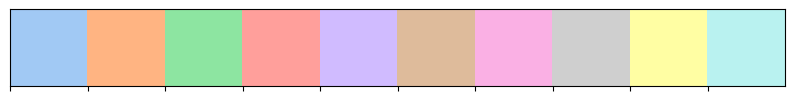

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

# I set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

# node colors for drawing networks
colors = sns.color_palette('pastel', 10)
sns.palplot(colors)
sns.set_palette(colors)

## 5.1 社交网络数据

- 定义一个函数用于读取数据文件，每一行包含一条边，边用节点对表示。

In [5]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

- 读取 Facecook 数据集（可以从 [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html)下载）

In [6]:
# https://snap.stanford.edu/data/facebook_combined.txt.gz

fb = read_graph('C:/Users/Boyang  Du/Desktop/America works/network/facebook_combined.txt.gz')
n = len(fb)
m = len(fb.edges())
n, m

(4039, 88234)

- 对于较大的图，集聚系数和路径长度计算非常慢，花费的时间与 $nk^2$ 成正比，其中 $n$ 是节点数，$k$ 是每个节点连接到的相邻节点的数量。
- 幸运的是，NetworkX提供了一个函数，可以通过随机抽样估计集聚系数和路径长度。
- 可以使用如下代码调用该函数：

In [7]:
from networkx.algorithms.approximation import average_clustering
average_clustering(fb, trials=1000)

0.628

这里循环一百次，得到集聚系数的精确值大约为0.607

In [8]:
i=1
s=0
while i<=100:
    s=s+average_clustering(fb, trials=1000)
    i=i+1
print(s/100)

0.6042999999999996


- 下面的函数对路径长度做了类似的处理。

In [9]:
def sample_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)
        
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair) 
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

- 测试平均集聚系数

In [10]:
C = average_clustering(fb)
C

0.59

这里把平均集聚系数循环100次，得到均值大约为0.603

In [11]:
i=1
s=0
while i<=100:
    s=s+average_clustering(fb)
    i=i+1
print(s/100)

0.6065499999999999


- 测试平均路径长度

In [12]:
L = estimate_path_length(fb)
L

3.717

平均路径长大约为3.68

In [13]:
i=1
s=0
while i<=10:
    s=s+estimate_path_length(fb)
    i=i+1
print(s/10)

3.6809


- 如下函数返回一个度列表。

In [14]:
def degrees(G):
    """List of degrees for nodes in `G`.
    
    G: Graph object
    
    returns: list of int
    """
    return [G.degree(u) for u in G]

## 5.2 BA 模型

- 这里给出生成BA图的简化版本。

In [15]:
# modified version of the NetworkX implementation from
# https://github.com/networkx/networkx/blob/master/networkx/generators/random_graphs.py

import random

def barabasi_albert_graph(n, k, seed=None):
    """Constructs a BA graph.
    
    n: number of nodes
    k: number of edges for each new node
    seed: random seen
    """
    if seed is not None:
        random.seed(seed)
    
    G = nx.empty_graph(k)
    targets = set(range(k))
    repeated_nodes = []

    for source in range(k, n):

        G.add_edges_from(zip([source]*k, targets))

        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * k)

        targets = _random_subset(repeated_nodes, k)

    return G

- 这里给出产生不重复随机子集的函数。

In [16]:
def _random_subset(repeated_nodes, k):
    """Select a random subset of nodes without repeating.
    
    repeated_nodes: list of nodes
    k: size of set
    
    returns: set of nodes
    """
    targets = set()
    while len(targets) < k:
        x = random.choice(repeated_nodes)
        targets.add(x)
    return targets

- 我们生成和Facebook数据集具有相同节点和边的BA图。

In [17]:
n = len(fb)
m = len(fb.edges())
k = int(round(m/n))
n, m, k

(4039, 88234, 22)

- 采用随机种子使得每次产生同样的图。

In [18]:
ba = barabasi_albert_graph(n, k, seed=15)

- 检查BA图边的数量。

In [19]:
len(ba), len(ba.edges()), len(ba.edges())/len(ba)

(4039, 88374, 21.88016835850458)

- 平均度

In [20]:
np.mean(degrees(fb)), np.mean(degrees(ba))

(43.69101262688784, 43.76033671700916)

- 度的标准差

In [21]:
np.std(degrees(fb)), np.std(degrees(ba))

(52.41411556737521, 41.03760075705614)

- 度分布

In [22]:
from empiricaldist import Pmf

pmf_fb = Pmf.from_seq(degrees(fb))
pmf_ba = Pmf.from_seq(degrees(ba))

- 在双对数坐标下绘制度分布。

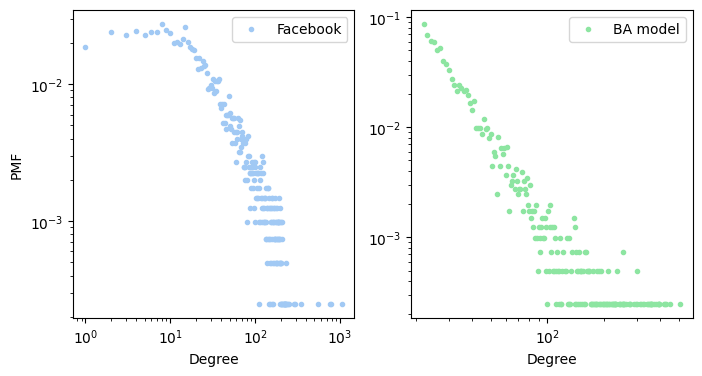

In [24]:
plt.figure(figsize=(8,4))
options = dict(ls='', marker='.')

plt.subplot(1,2,1)
pmf_fb.plot(label='Facebook', color='C0', **options)
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
pmf_ba.plot(label='BA model', color='C2', **options)
plt.xlabel('Degree')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')


- 平均路径长度

In [25]:
L, estimate_path_length(ba)

(3.717, 2.477)

- 集聚系数

In [29]:
C, average_clustering(ba)

(0.59, 0.038)

## 5.3 使用NetworkX自带函数生成BA图

- NetworkX提供了一个生成BA图的函数。

In [30]:
ba = nx.barabasi_albert_graph(4039, 22)

In [32]:
ba2 = nx.barabasi_albert_graph(2023, 22)

- 检查BA图边的数量。

In [31]:
len(ba), len(ba.edges()), len(ba.edges())/len(ba)

(4039, 88374, 21.88016835850458)

In [33]:
len(ba2), len(ba2.edges()), len(ba2.edges())/len(ba2)

(2023, 44022, 21.760751359367276)

- 平均度

In [34]:
np.mean(degrees(fb)), np.mean(degrees(ba))

(43.69101262688784, 43.76033671700916)

In [35]:
np.mean(degrees(fb)), np.mean(degrees(ba2))

(43.69101262688784, 43.52150271873455)

- 度的标准差

In [83]:
np.std(degrees(fb)), np.std(degrees(ba))

(52.41411556737521, 41.61005746075241)

In [36]:
np.std(degrees(fb)), np.std(degrees(ba2))

(52.41411556737521, 36.84005599171815)

- 度分布

In [40]:
from empiricaldist import Pmf

pmf_fb = Pmf.from_seq(degrees(fb))
pmf_ba = Pmf.from_seq(degrees(ba))

In [43]:
pmf_ba2 = Pmf.from_seq(degrees(ba2))

- 在双对数坐标下绘制度分布。

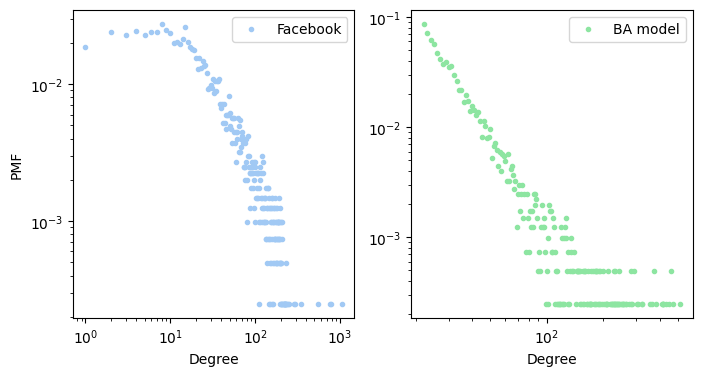

In [44]:
plt.figure(figsize=(8,4))
options = dict(ls='', marker='.')

plt.subplot(1,2,1)
pmf_fb.plot(label='Facebook', color='C0', **options)
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
pmf_ba.plot(label='BA model', color='C2', **options)
plt.xlabel('Degree')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')

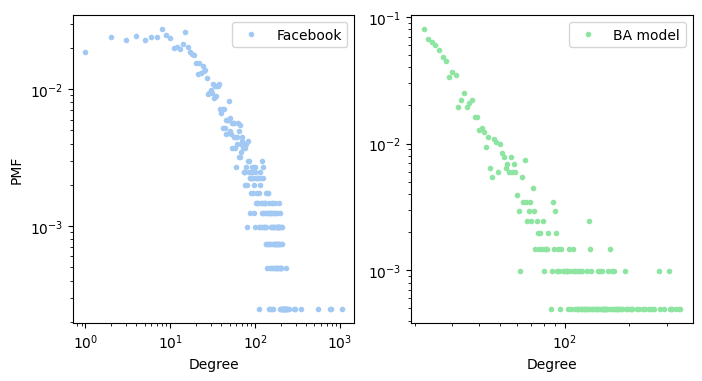

In [45]:
plt.figure(figsize=(8,4))
options = dict(ls='', marker='.')

plt.subplot(1,2,1)
pmf_fb.plot(label='Facebook', color='C0', **options)
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
pmf_ba2.plot(label='BA model', color='C2', **options)
plt.xlabel('Degree')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')

- 平均路径长度

In [48]:
L, estimate_path_length(ba)

(3.717, 2.51)

In [49]:
L, estimate_path_length(ba2)

(3.717, 2.304)

- 集聚系数

In [91]:
C, average_clustering(ba)

(0.61, 0.043)

In [50]:
C, average_clustering(ba2)

(0.59, 0.071)

## 5.4 累积分布函数

- 如下函数用于计算累计分布概率。

In [51]:
def cumulative_prob(pmf, x):
    """Computes the cumulative probability of `x`.
    
    Total probability of all values <= x.
    
    returns: float probability
    """
    ps = [pmf[value] for value in pmf.qs if value<=x]
    return np.sum(ps)

- 测试

In [52]:
cumulative_prob(pmf_fb, 11)

0.2577370636296113

In [54]:
cumulative_prob(pmf_ba2, 11)

0.0

- 中位数

In [55]:
cumulative_prob(pmf_fb, 25)

0.5060658578856152

- 测试

In [56]:
cumulative_prob(pmf_fb, 57)

0.751671205743996

- 从 `empiricaldist` 导入`Cdf` 包。

In [57]:
from empiricaldist import Cdf

- 计算 Facebook 数据集, WS模型和BA模型的累积分布。

In [61]:
cdf_fb = Cdf.from_seq(degrees(fb), name='Facebook')
cdf_fb

,probs
1,0.018569
2,0.042832
3,0.065858
4,0.090369
5,0.113394
...,...
347,0.999010
547,0.999257
755,0.999505
792,0.999752


In [62]:
ws = nx.watts_strogatz_graph(n, k, 0.05, seed=15)
cdf_ws = Cdf.from_seq(degrees(ws), name='WS model')
cdf_ws

,probs
18,0.001733
19,0.009161
20,0.062887
21,0.286457
22,0.718742
23,0.933152
24,0.989106
25,0.998762
26,1.000000


In [63]:
cdf_ba = Cdf.from_seq(degrees(ba), name='BA model')
cdf_ba

,probs
22,0.086160
23,0.158455
24,0.220847
25,0.278287
26,0.325576
...,...
434,0.998762
449,0.999010
457,0.999505
472,0.999752


In [64]:
np.random.random(2)

array([0.9635448 , 0.40232918])

- 绘制在WS模型和BA模型x对数尺度下得到的Facebook数据集中度的CDF。

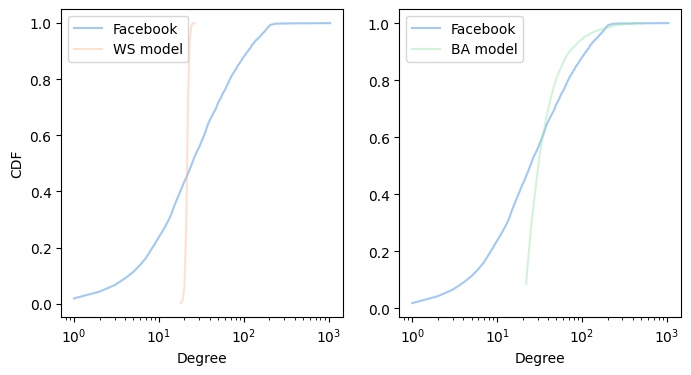

In [66]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
cdf_fb.plot(color='C0', label='Facebook')
cdf_ws.plot(color='C1', alpha=0.4, label='WS model')
plt.xlabel('Degree')
plt.ylabel('CDF')
plt.xscale('log')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
cdf_fb.plot(color='C0', label='Facebook')
cdf_ba.plot(color='C2', alpha=0.4, label='BA model')
plt.xlabel('Degree')
plt.xscale('log')
plt.legend(loc='upper left')


- 双对数坐标绘图

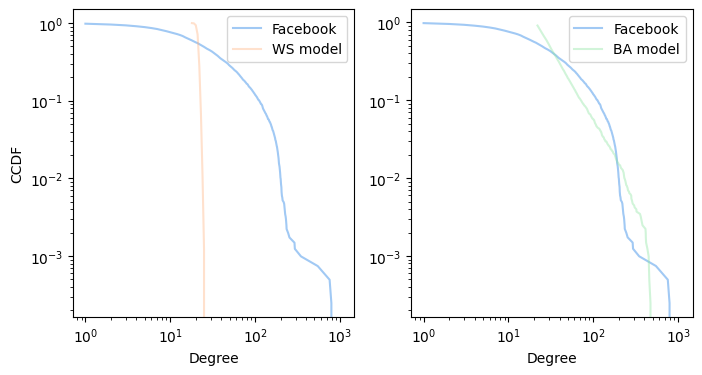

In [67]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
(1 - cdf_fb).plot(color='C0', label='Facebook')
(1 - cdf_ws).plot(color='C1', alpha=0.4, label='WS model')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
(1 - cdf_fb).plot(color='C0', label='Facebook')
(1 - cdf_ba).plot(color='C2', alpha=0.4, label='BA model')
plt.xlabel('Degree')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')


练习：按照累计概率编写BA模型代码。